# Generalized Lotka Volterra

We consider a Generalized Lotka Volterra system with $3$ populations
$$
\frac{\partial}{\partial t}u_i(t) = r_iu_i(t) - \sum_{j\neq i}\alpha_{ij}u_j(t)
-\alpha_{i,i}u_i(t) + c_iu_i(t) + \sum_{j \neq i} c_ju_j(t), i\in\{1, 2, 3\}
$$

More information on this ODE system can be found at [https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation](https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

2024-09-16 16:30:44.019323: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [5]:
eqx_list = [
    [eqx.nn.Linear, 1, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1],
    [jnp.exp]
]
key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "ODE")

In [6]:
init_nn_params = u.init_params()

Create a DataGenerator object

In [7]:
n = 320
batch_size = 32
method = 'uniform'
tmin = 0
tmax = 1

Tmax = 30
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    subkey,
    n,
    tmin,
    tmax,
    batch_size,
    method=method
)

Initialize 3 set of neural network parameters for the 3 populations

In [8]:
init_nn_params_list = []
for _ in range(3):
    key, subkey = random.split(key)
    u = jinns.utils.create_PINN(subkey, eqx_list, "ODE", 0)
    init_nn_params = u.init_params()
    init_nn_params_list.append(init_nn_params)

### Model parameters




In [9]:
# initial conditions for each species
N_0 = jnp.array([10., 7., 4.])
# growth rates for each species
growth_rates = jnp.array([0.1, 0.5, 0.8])
# carrying capacity for each species
carrying_capacities = jnp.array([0.04, 0.02, 0.02])
# interactions
# NOTE that for the interaction between the species **with itself** is always at position 0
# NOTE minus sign
interactions = -jnp.array([[0, 0.001, 0.001], [0, 0.001, 0.001], [0, 0.001, 0.001]])

A set of parameters as required by the losses' `evaluate` method is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary.

__Note__ that `nn_params` and `eq_params` must always be top level keys but can be nested dictionaries.

__Note__ that the keys of the sub dictionaries `nn_params` and `eq_params` (here `str(i)`) can differ !

In [10]:
init_params = jinns.parameters.ParamsDict(
    nn_params={str(i): init_nn_params_list[i] for i in range(3)},
    eq_params={
        str(i): {
            "carrying_capacity": carrying_capacities[i],
            "growth_rate": growth_rates[i],
            "interactions": interactions[i, :],
        }
        for i in range(3)
    },
)

Visualize the output of the neural networks before the parameter learning step

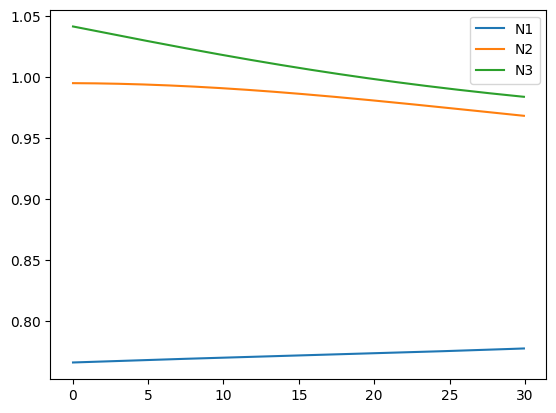

In [11]:
vectorized_u_init = vmap(lambda t: u(t, init_params.extract_params("0")), (0), 0)
vectorized_v_init = vmap(lambda t: u(t, init_params.extract_params("1")), (0), 0)
vectorized_w_init = vmap(lambda t: u(t, init_params.extract_params("2")), (0), 0)


plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_u_init(train_data.times.sort(axis=0)), label="N1")
plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_v_init(train_data.times.sort(axis=0)), label="N2")
plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_w_init(train_data.times.sort(axis=0)), label="N3")

plt.legend()

## Loss construction

We construct a SystemLossODE with GeneralizedLotkaVolterra losses for each population. Here `key_main` refer to the key in the dictionnary field `params.nn_params` which are the parameters for the main PINN of the equation (the PINN which represents the solution differentiated with respect to the `t`). In addition, `key_others` refer to the keys in `param.nn_params` which are the parameters for the PINNs interacting with `key_main`.

In [12]:
N1_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(
    key_main="0", keys_other=["1", "2"], Tmax=Tmax
)
N2_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(
    key_main="1", keys_other=["0", "2"], Tmax=Tmax
)
N3_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(
    key_main="2", keys_other=["0", "1"], Tmax=Tmax
)


In [13]:
loss_weights = jinns.loss.LossWeightsODEDict(dyn_loss=1, initial_condition=1 * Tmax)

loss = jinns.loss.SystemLossODE(
    u_dict={"0": u, "1": u, "2": u},
    loss_weights=loss_weights,
    dynamic_loss_dict={
        "0": N1_dynamic_loss,
        "1": N2_dynamic_loss,
        "2": N3_dynamic_loss,
    },
    initial_condition_dict={
        "0": (float(tmin), N_0[0]),
        "1": (float(tmin), N_0[1]),
        "2": (float(tmin), N_0[2]),
    },
)

In [14]:
# Testing the loss function
train_data, batch = train_data.get_batch()

losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    batch
)
l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 4579.3173828125
Individual losses: {'dyn_loss': '676.83', 'initial_condition': '3902.49', 'observations': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [15]:
params = init_params

In [16]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)

In [17]:
n_iter = int(50000)

In [18]:
key, subkey = random.split(key)

In [19]:
params, total_loss_list, loss_by_term_dict, data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)

[train] Iteration 0: loss value = 4579.08984375
[train] Iteration 1000: loss value = 295.6667785644531
[train] Iteration 2000: loss value = 232.7814178466797
[train] Iteration 3000: loss value = 152.02993774414062
[train] Iteration 4000: loss value = 96.32563781738281
[train] Iteration 5000: loss value = 58.46765899658203
[train] Iteration 6000: loss value = 36.29928970336914
[train] Iteration 7000: loss value = 22.703493118286133
[train] Iteration 8000: loss value = 15.593758583068848
[train] Iteration 9000: loss value = 12.353331565856934
[train] Iteration 10000: loss value = 7.3760666847229
[train] Iteration 11000: loss value = 4.5367350578308105
[train] Iteration 12000: loss value = 4.927757740020752
[train] Iteration 13000: loss value = 2.2240560054779053
[train] Iteration 14000: loss value = 1.8380061388015747
[train] Iteration 15000: loss value = 1.4412355422973633
[train] Iteration 16000: loss value = 0.9397577047348022
[train] Iteration 17000: loss value = 0.9116711616516113
[

In [20]:
total_loss_list[-1]

Array(0.04294545, dtype=float32)

## Results

Plot the loss values

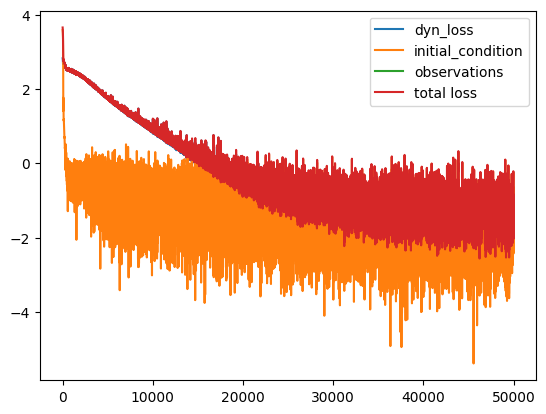

In [21]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()

Plot the ODE solutions learned by the PINN

<Axes: xlabel='t'>

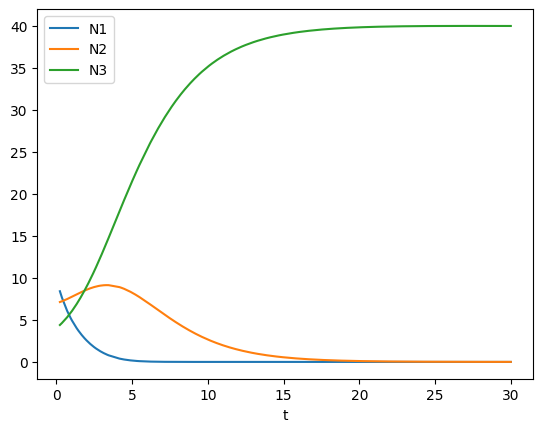

In [22]:
u_est_fp = vmap(lambda t:u(t, params.extract_params("0")), (0), 0)
v_est_fp = vmap(lambda t:u(t, params.extract_params("1")), (0), 0)
w_est_fp = vmap(lambda t:u(t, params.extract_params("2")), (0), 0)


key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(subkey, n, tmin, tmax, batch_size, method)

import pandas as pd
ts = val_data.times.sort(axis=0)
df = pd.DataFrame(
    {
        "t": ts * Tmax, # rescale time for plotting
        "N1": u_est_fp(ts).squeeze(),
        "N2": v_est_fp(ts).squeeze(),
        "N3": w_est_fp(ts).squeeze(),
        "Method": "PINN"
    },
)
df.plot(x="t")

## Compare with the scipy solver
Code from Lorenzo Sala

In [23]:
import numpy as np
from scipy.integrate import odeint

# NOTE the following line is not accurate as it skips one batch

def lotka_volterra_log(y_log, t, eq_params):
    """
    Generalized Lotka-Volterra model for N bacterial species, with logarithmic transformation for stability.

    Parameters:
        y_log (array): Array of log-transformed bacterial populations.
        t (float): Time.
        params (tuple): Tuple of model parameters.

    Returns:
        dydt (array): Array of derivative of log-transformed bacterial populations with respect to time.
    """
    alpha, beta, gamma, _ = eq_params
    N = len(y_log)
    y = np.exp(y_log)
    dydt = np.zeros(N)

    for i in range(N):
        dydt[i] = y[i] * (alpha[i] - beta[i] * np.sum(y) - np.sum([gamma[j][i] * y[j] for j in range(N)]))

    dydt_log = dydt / y

    return dydt_log

# Define name bacteria
names = ['N1', 'N2', 'N3']
N = len(names)

# Define model parameters
death_rates = None
eq_params = (growth_rates, carrying_capacities, interactions, death_rates)

# Define initial bacterial populations
y0 = [10, 7, 4] #[0.26, 0.37, 0.57] #

# Define time points
Tmax = 30
t = ts * Tmax

############################

y0_log = np.log(y0)
y_log = odeint(lotka_volterra_log, y0_log, t, args=(eq_params,))
y = np.exp(y_log)

In [24]:
# comparative plots
df_scipy = pd.DataFrame(
    {
        "t": ts * Tmax, # rescale time for plotting
        "Method": "Scipy solver"
    } |
    {
        f"N{i+1}": y[:,i] for i in range(3)
    },
)



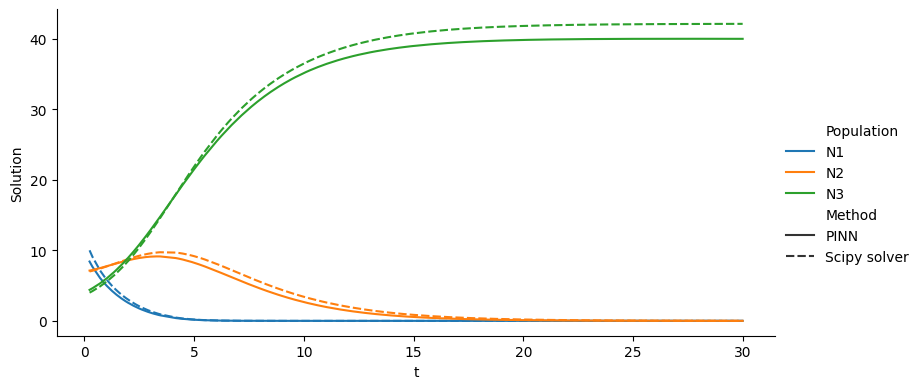

In [32]:
import seaborn as sns
df_plot = pd.concat((df, df_scipy)).melt(id_vars=['Method', "t"], var_name="Population", value_name="Solution")
sns.relplot(df_plot, kind='line', x='t', y='Solution', hue='Population',  style='Method', height=4, aspect=2)